# Pedestrian Classification with Normalized HOG Features

This notebook implements pedestrian classification using normalized HOG (Histogram of Oriented Gradients) features.

In [39]:
import os, cv2, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [40]:
# Create directories
os.makedirs("Models", exist_ok=True)
os.makedirs("Results", exist_ok=True)

In [ ]:
#load data functions

def load_pos(folder):
    """Load positive samples (pedestrians)"""
    imgs = []
    for f in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, f))
        if img is not None:
            imgs.append(cv2.resize(img, (64, 128)))
    return imgs

def load_neg(folder, n=5):
    """Load negative samples (non-pedestrians)"""
    imgs = []
    for f in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, f))
        if img is None: 
            continue
        h, w, _ = img.shape
        for _ in range(n):
            x = np.random.randint(0, w-64)
            y = np.random.randint(0, h-128)
            imgs.append(img[y:y+128, x:x+64])
    return imgs

In [ ]:
# Load data
train_pos = load_pos("../INRIAPerson/Train/pos")
train_neg = load_neg("../INRIAPerson/Train/neg")

val_pos = load_pos("../INRIAPerson/Validation/pos")
val_neg = load_neg("../INRIAPerson/Validation/neg")

X_train_imgs = train_pos + train_neg
y_train = np.array([1]*len(train_pos) + [0]*len(train_neg))

X_val_imgs = val_pos + val_neg
y_val = np.array([1]*len(val_pos) + [0]*len(val_neg))

print(f"Train samples: {len(X_train_imgs)}")
print(f"Validation samples: {len(X_val_imgs)}")

Train samples: 4639
Validation samples: 944


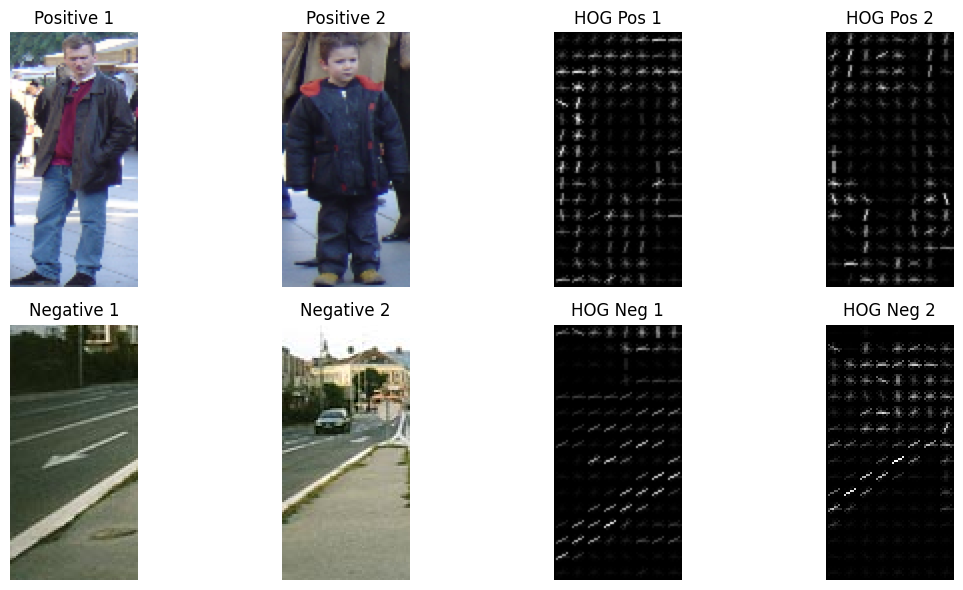

In [43]:
# Visualize sample images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Show positive samples
for i in range(2):
    img = cv2.cvtColor(train_pos[i], cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Positive {i+1}')
    axes[0, i].axis('off')

# Show negative samples
for i in range(2):
    img = cv2.cvtColor(train_neg[i], cv2.COLOR_BGR2RGB)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Negative {i+1}')
    axes[1, i].axis('off')

# Show HOG visualizations
for i in range(2):
    gray_pos = cv2.cvtColor(train_pos[i], cv2.COLOR_BGR2GRAY)
    gray_neg = cv2.cvtColor(train_neg[i], cv2.COLOR_BGR2GRAY)
    
    _, hog_pos = hog(gray_pos, orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2), visualize=True)
    _, hog_neg = hog(gray_neg, orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2), visualize=True)
    
    axes[0, i+2].imshow(hog_pos, cmap='gray')
    axes[0, i+2].set_title(f'HOG Pos {i+1}')
    axes[0, i+2].axis('off')
    
    axes[1, i+2].imshow(hog_neg, cmap='gray')
    axes[1, i+2].set_title(f'HOG Neg {i+1}')
    axes[1, i+2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Extract HOG features function
def extract_hog_features(images):
    """Extract HOG features from images"""
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8), 
                      cells_per_block=(2, 2), visualize=False)
        features.append(hog_feat)
    return np.array(features)

In [45]:
# Extract HOG features
print("Extracting HOG features...")
X_train_hog = extract_hog_features(X_train_imgs)
X_val_hog = extract_hog_features(X_val_imgs)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_hog)
X_val = scaler.transform(X_val_hog)
joblib.dump(scaler, "Models/scaler.joblib")


print(f"Feature shape: {X_train.shape}")

Extracting HOG features...
Feature shape: (4639, 3780)


In [ ]:
# Define models with optimized hyperparameters
models = {
    'SVM': SVC(
        C=1,
        kernel='rbf', 
        gamma='scale', 
        probability=True, 
        random_state=42
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100,), 
        activation='relu', 
        solver='adam', 
        alpha=0.001, 
        learning_rate='constant', 
        max_iter=1000, 
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=500,       
        max_depth=3,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=42,
        eval_metric='logloss'    
    ),
    'Logistic Regression': LogisticRegression(
        C=0.01, 
        solver='lbfgs', 
        penalty='l2', 
        max_iter=2000, 
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=3, 
        weights='distance', 
        metric='manhattan'
    )
}


Training SVM...
SVM Results -> Train: 0.9987, Val: 0.9746

Classification Report:
                precision    recall  f1-score   support

Non-Pedestrian       0.97      0.99      0.98       660
    Pedestrian       0.97      0.94      0.96       284

      accuracy                           0.97       944
     macro avg       0.97      0.96      0.97       944
  weighted avg       0.97      0.97      0.97       944



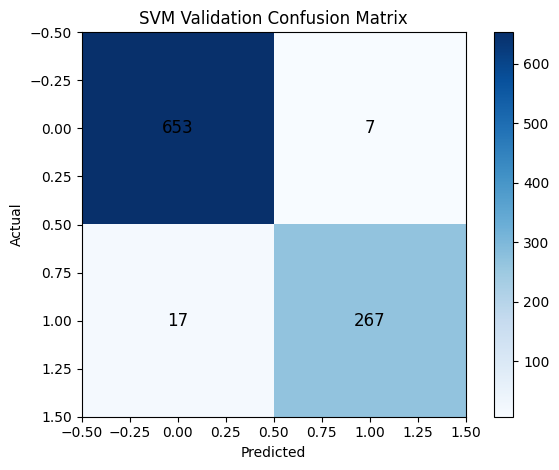

Training Neural Network...
Neural Network Results -> Train: 1.0000, Val: 0.9703

Classification Report:
                precision    recall  f1-score   support

Non-Pedestrian       0.98      0.98      0.98       660
    Pedestrian       0.95      0.95      0.95       284

      accuracy                           0.97       944
     macro avg       0.96      0.96      0.96       944
  weighted avg       0.97      0.97      0.97       944



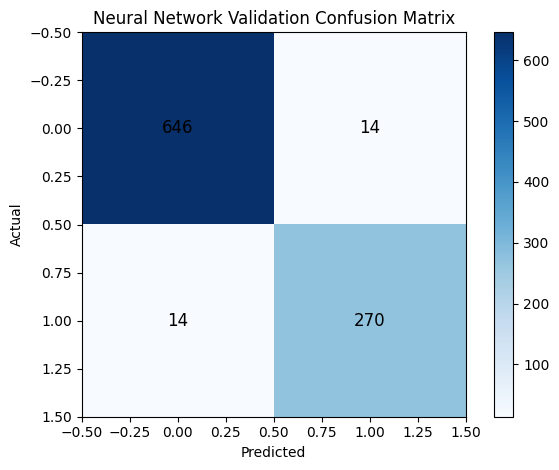

Training XGBoost...
XGBoost Results -> Train: 1.0000, Val: 0.9703

Classification Report:
                precision    recall  f1-score   support

Non-Pedestrian       0.98      0.98      0.98       660
    Pedestrian       0.95      0.95      0.95       284

      accuracy                           0.97       944
     macro avg       0.97      0.96      0.96       944
  weighted avg       0.97      0.97      0.97       944



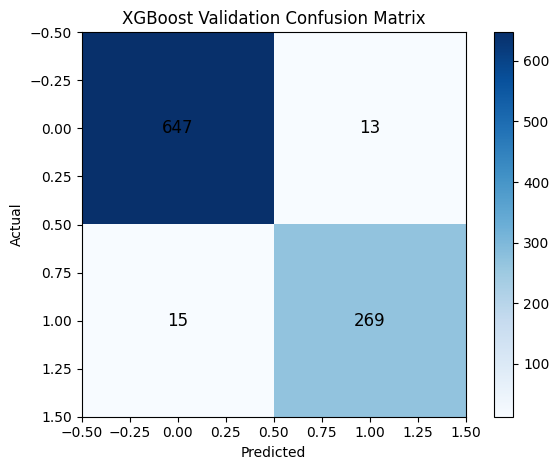

Training Logistic Regression...
Logistic Regression Results -> Train: 0.9998, Val: 0.9587

Classification Report:
                precision    recall  f1-score   support

Non-Pedestrian       0.96      0.98      0.97       660
    Pedestrian       0.95      0.92      0.93       284

      accuracy                           0.96       944
     macro avg       0.95      0.95      0.95       944
  weighted avg       0.96      0.96      0.96       944



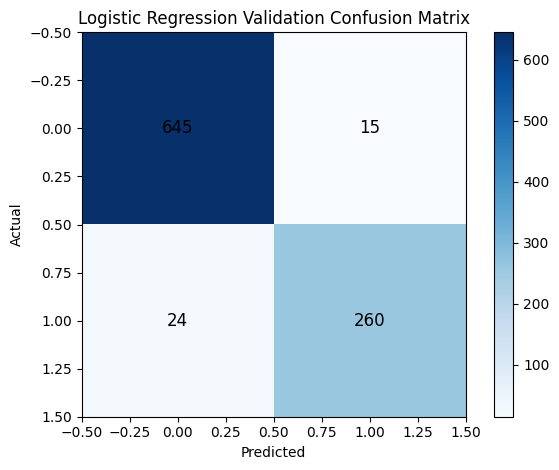

Training Random Forest...
Random Forest Results -> Train: 1.0000, Val: 0.9301

Classification Report:
                precision    recall  f1-score   support

Non-Pedestrian       0.92      0.99      0.95       660
    Pedestrian       0.97      0.79      0.87       284

      accuracy                           0.93       944
     macro avg       0.94      0.89      0.91       944
  weighted avg       0.93      0.93      0.93       944



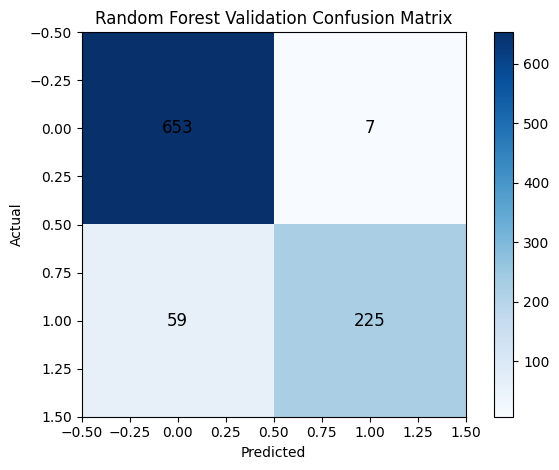

Training KNN...
KNN Results -> Train: 1.0000, Val: 0.8581

Classification Report:
                precision    recall  f1-score   support

Non-Pedestrian       0.83      1.00      0.91       660
    Pedestrian       1.00      0.53      0.69       284

      accuracy                           0.86       944
     macro avg       0.92      0.76      0.80       944
  weighted avg       0.88      0.86      0.84       944



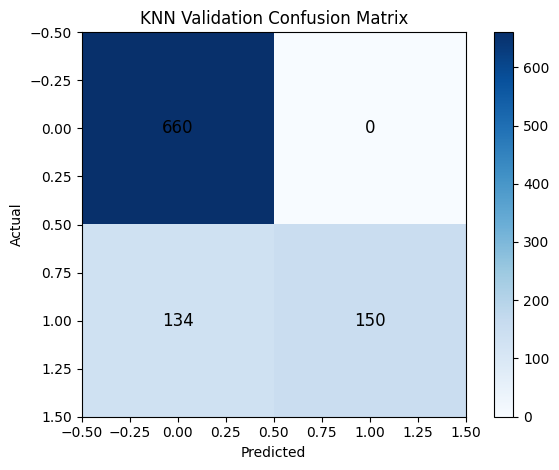


FINAL PERFORMANCE SUMMARY
                 Model  Train_Acc   Val_Acc  Overfit_Gap
0                  SVM   0.998707  0.974576     0.024130
1       Neural Network   1.000000  0.970339     0.029661
2              XGBoost   1.000000  0.970339     0.029661
3  Logistic Regression   0.999784  0.958686     0.041098
4        Random Forest   1.000000  0.930085     0.069915
5                  KNN   1.000000  0.858051     0.141949
Best Model: SVM
Validation Accuracy: 0.9746


In [ ]:

# Train and Evaluate Models
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    results.append({
        'Model': name,
        'Train_Acc': train_acc,
        'Val_Acc': val_acc,
        'Overfit_Gap': train_acc - val_acc
    })
    
    joblib.dump(model, f"Models/{name.replace(' ', '_')}.joblib")
    print(f"{name} Results -> Train: {train_acc:.4f}, Val: {val_acc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_val, val_pred, target_names=['Non-Pedestrian', 'Pedestrian']))

    # Confusion Matrix
    cm = confusion_matrix(y_val, val_pred)
    plt.figure()
    plt.imshow(cm, cmap='Blues')
    plt.title(f"{name} Validation Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.colorbar()
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color='black', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    plt.close()

# Save Final Comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Val_Acc', ascending=False)
results_df.to_csv('Results/final_model_performance.csv', index=False)
print("\n" + "="*30)
print("FINAL PERFORMANCE SUMMARY")
print("="*30)
print(results_df)

# Best model analysis
best_model_name = results_df.iloc[0]['Model']
best_model = joblib.load(f"Models/{best_model_name.replace(' ', '_')}.joblib")
print(f"Best Model: {best_model_name}")
print(f"Validation Accuracy: {results_df.iloc[0]['Val_Acc']:.4f}")






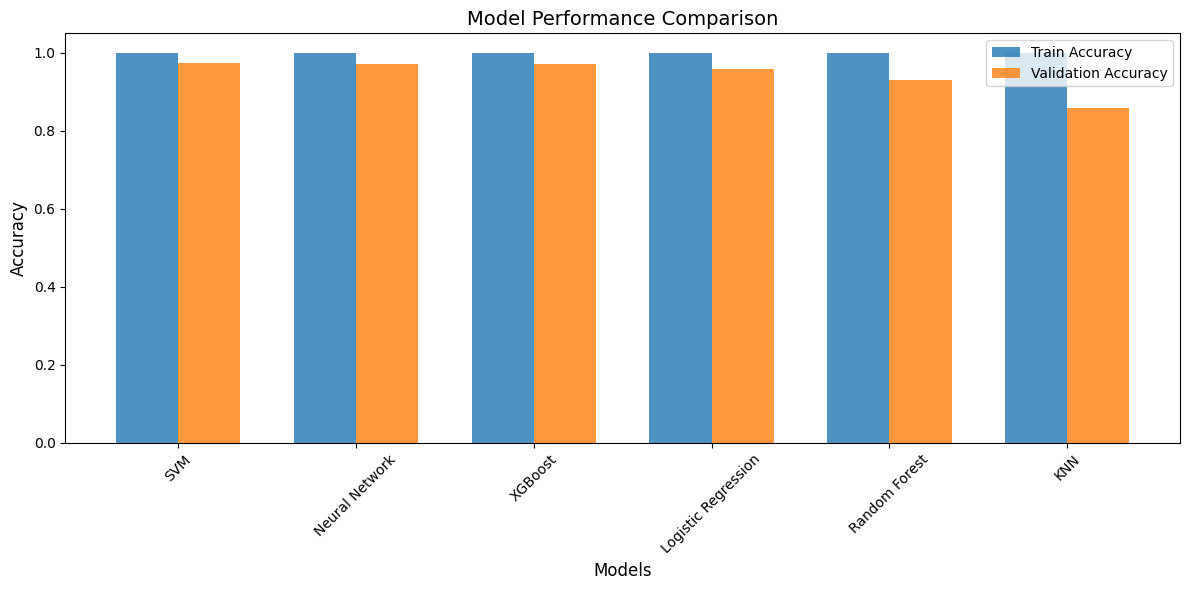

In [ ]:
# Sort results by Validation Accuracy
results_df = results_df.sort_values("Val_Acc", ascending=False)

# Bar positions
x_pos = np.arange(len(results_df))
width = 0.35

plt.figure(figsize=(12,6))

# Plot Train and Validation bars
plt.bar(x_pos - width/2, results_df['Train_Acc'], width, label='Train Accuracy', alpha=0.8)
plt.bar(x_pos + width/2, results_df['Val_Acc'], width, label='Validation Accuracy', alpha=0.8)

plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14)
plt.xticks(x_pos, results_df['Model'], rotation=45)
plt.ylim(0, 1.05)  

plt.legend()
plt.tight_layout()
plt.show()

Test samples: 944

Testing Model: SVM
SVM Test Accuracy: 0.9725
              precision    recall  f1-score   support

    Negative       0.97      0.99      0.98       660
    Positive       0.97      0.93      0.95       284

    accuracy                           0.97       944
   macro avg       0.97      0.96      0.97       944
weighted avg       0.97      0.97      0.97       944



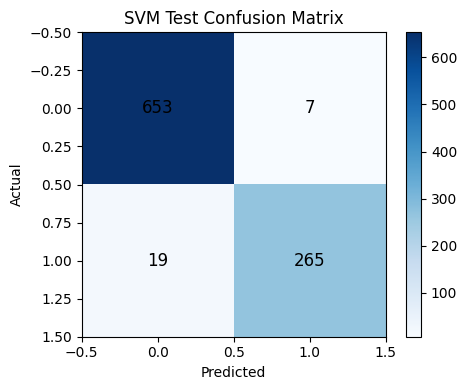

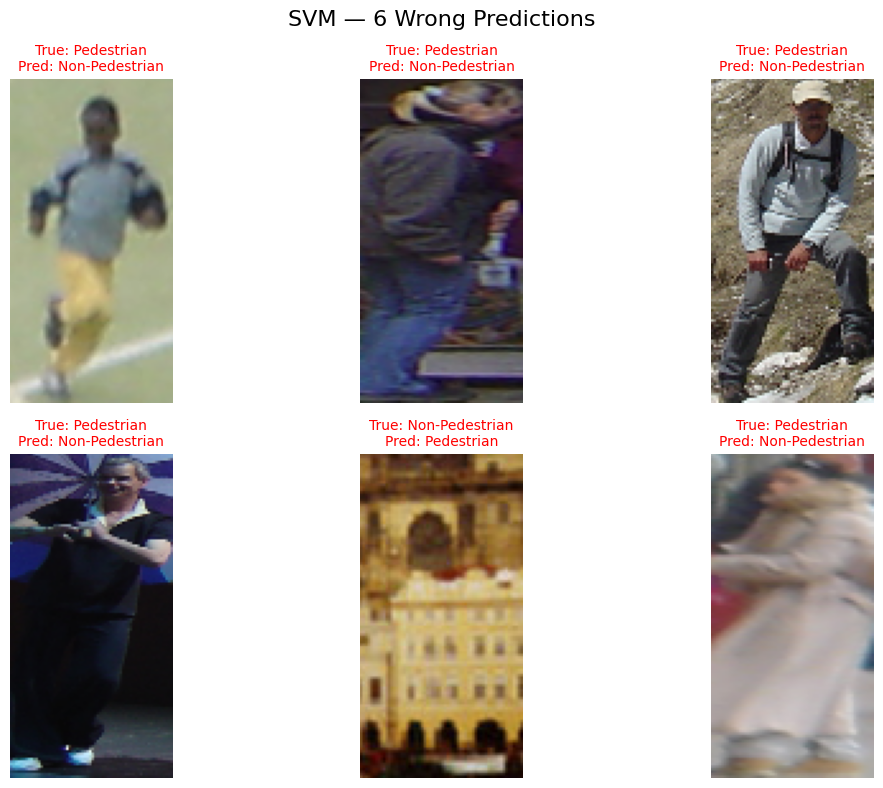

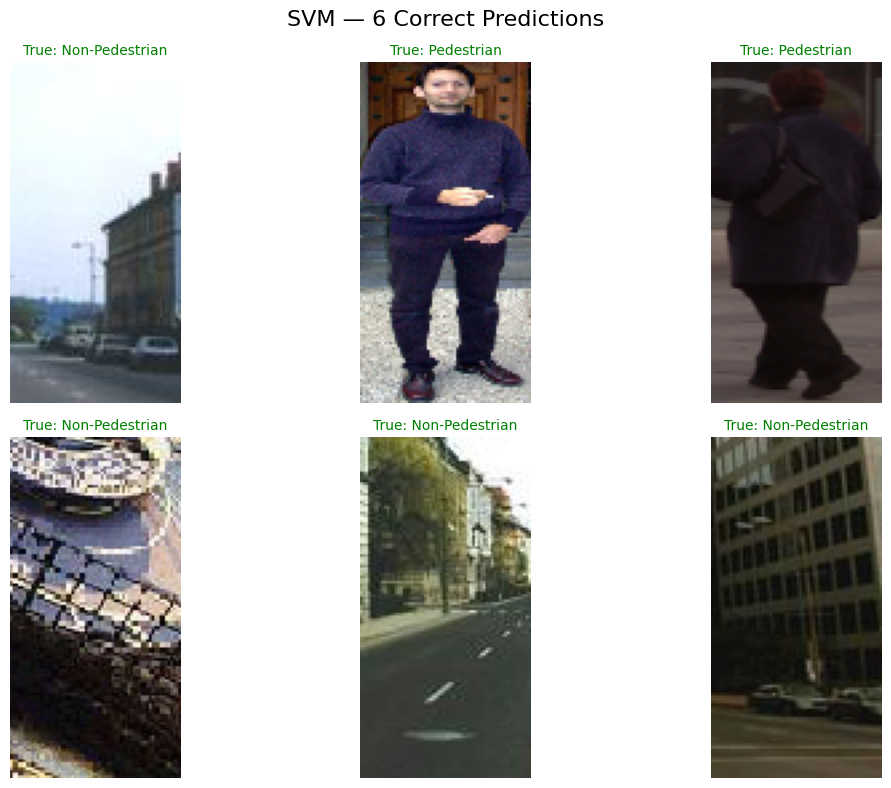


Testing Model: Random_Forest
Random_Forest Test Accuracy: 0.9343
              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96       660
    Positive       0.99      0.79      0.88       284

    accuracy                           0.93       944
   macro avg       0.95      0.89      0.92       944
weighted avg       0.94      0.93      0.93       944



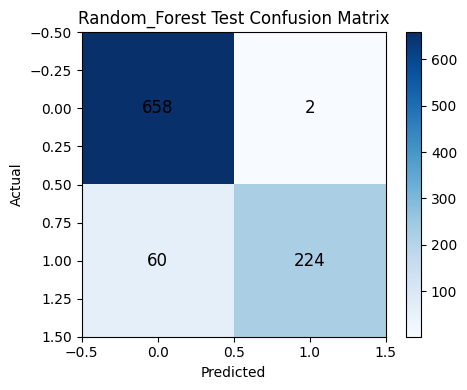

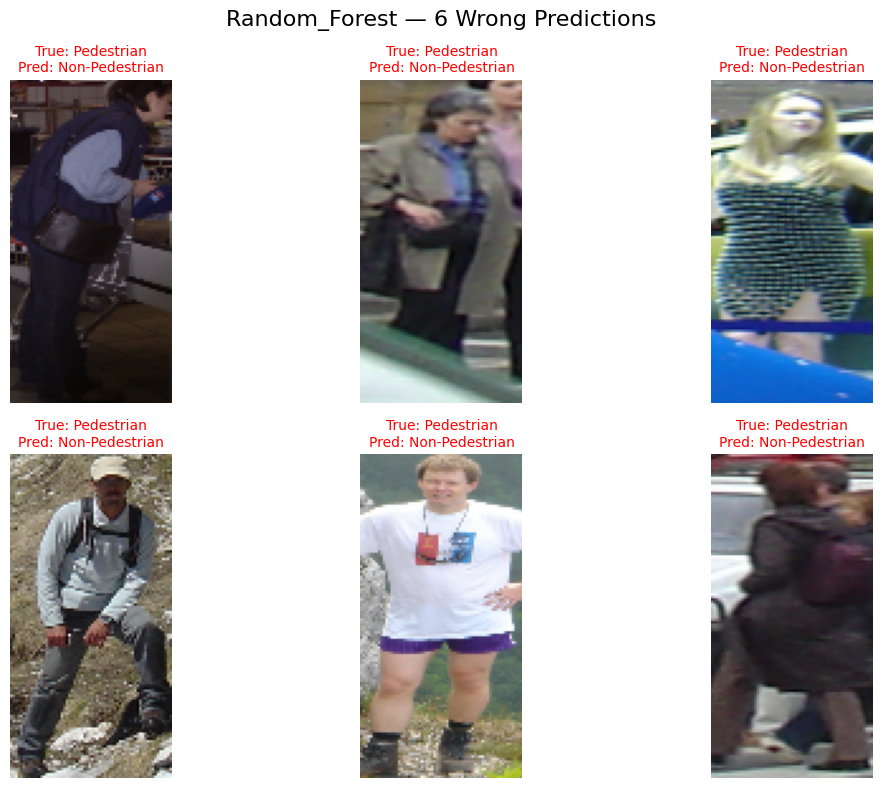

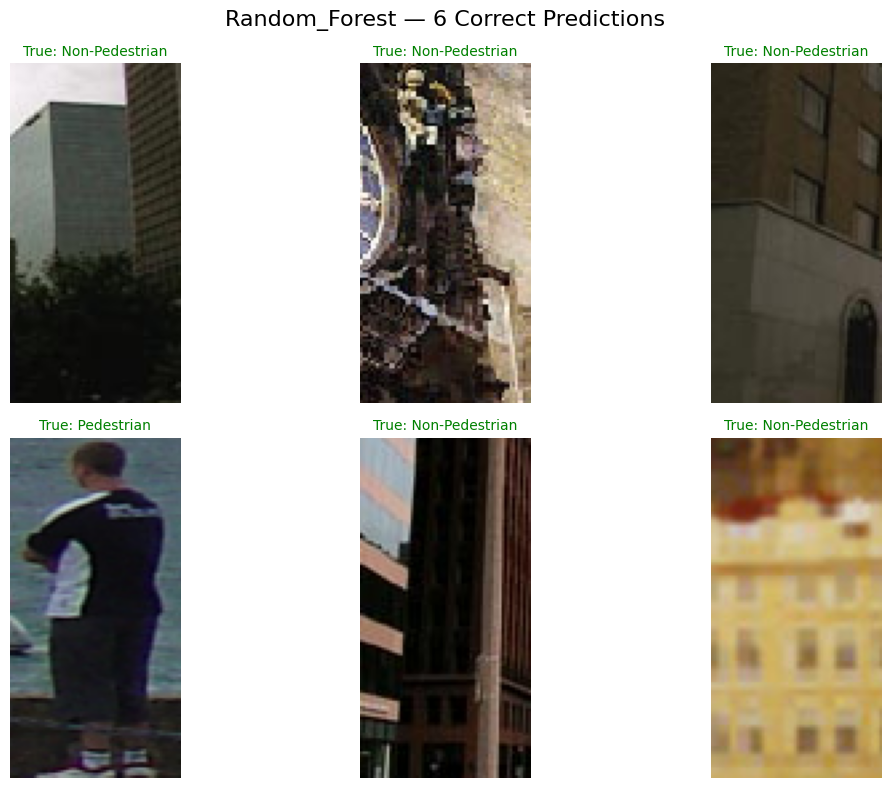


Testing Model: KNN
KNN Test Accuracy: 0.8326
              precision    recall  f1-score   support

    Negative       0.81      1.00      0.89       660
    Positive       1.00      0.44      0.61       284

    accuracy                           0.83       944
   macro avg       0.90      0.72      0.75       944
weighted avg       0.86      0.83      0.81       944



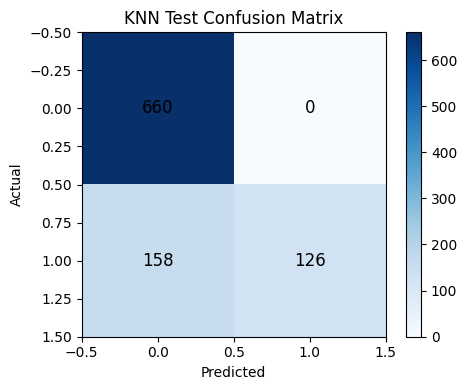

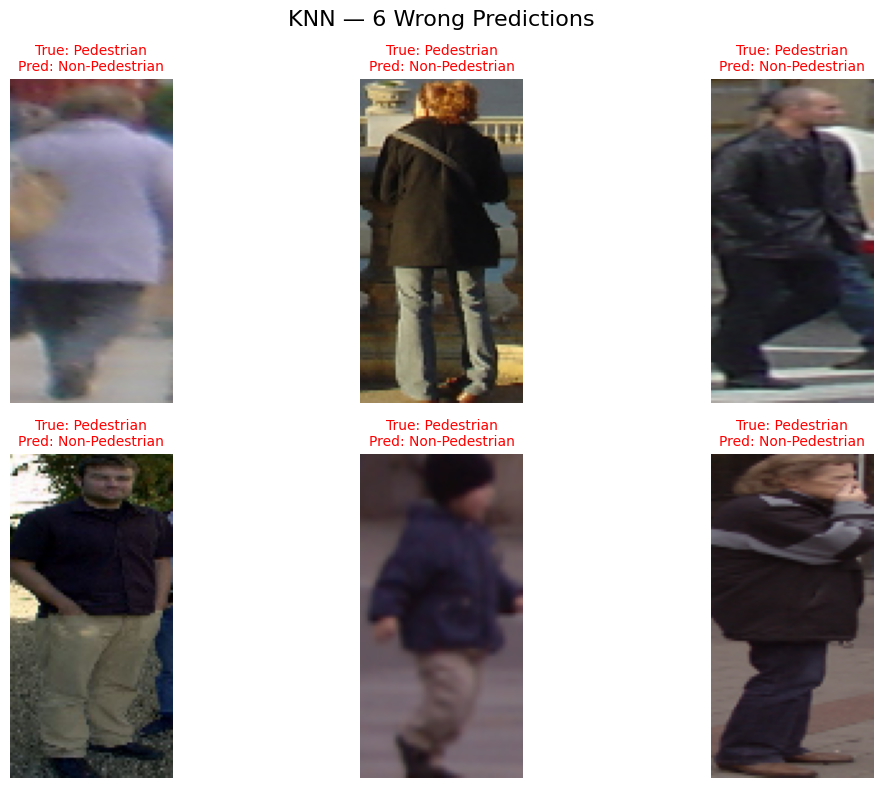

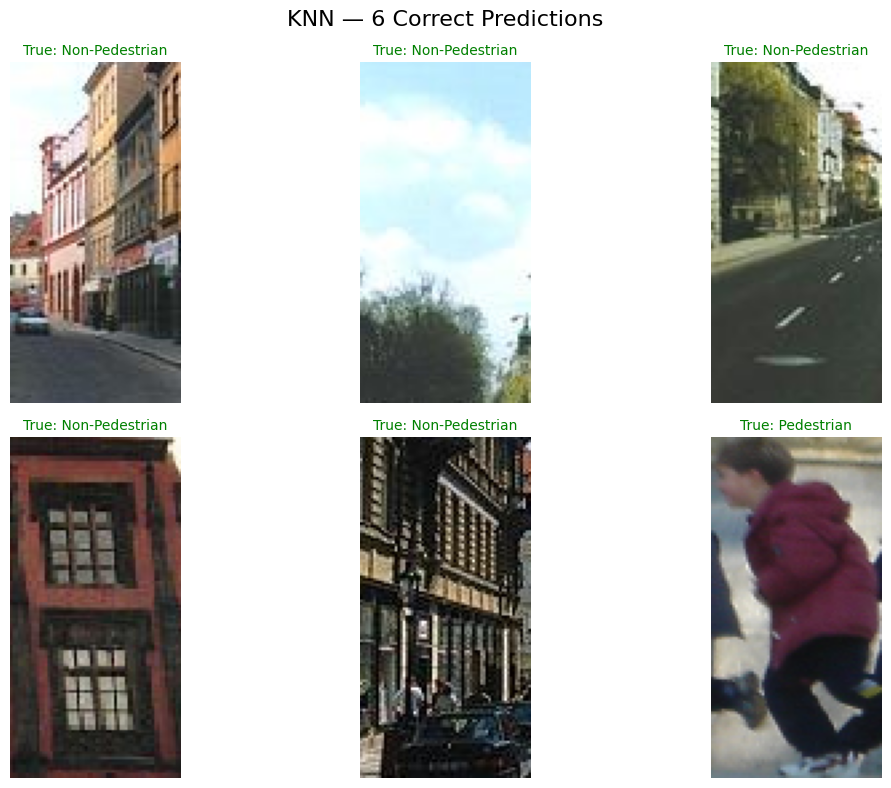


Testing Model: Logistic_Regression
Logistic_Regression Test Accuracy: 0.9587
              precision    recall  f1-score   support

    Negative       0.97      0.98      0.97       660
    Positive       0.94      0.92      0.93       284

    accuracy                           0.96       944
   macro avg       0.95      0.95      0.95       944
weighted avg       0.96      0.96      0.96       944



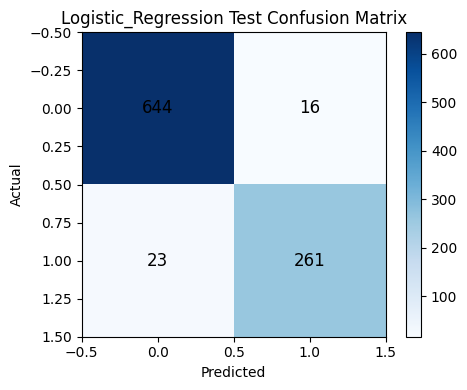

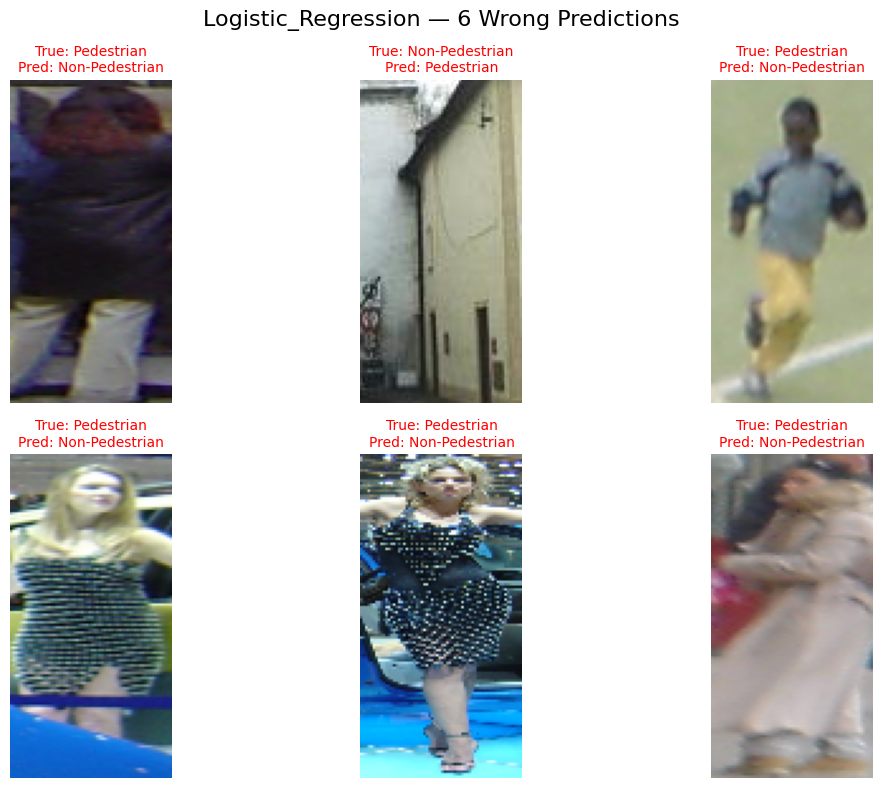

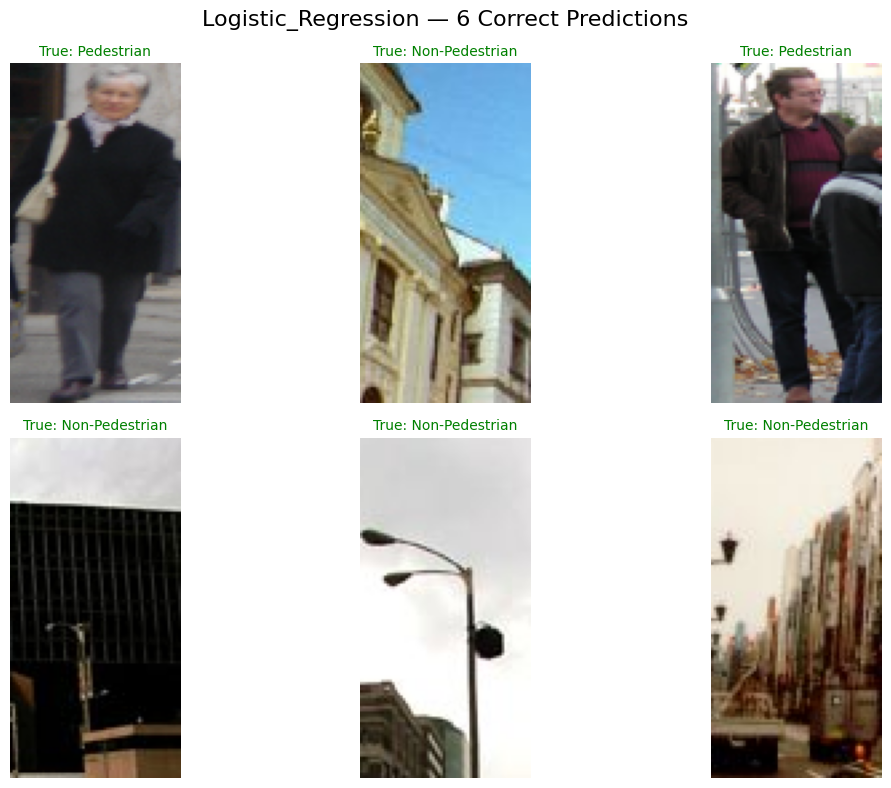


Testing Model: XGBoost
XGBoost Test Accuracy: 0.9608
              precision    recall  f1-score   support

    Negative       0.97      0.98      0.97       660
    Positive       0.95      0.92      0.93       284

    accuracy                           0.96       944
   macro avg       0.96      0.95      0.95       944
weighted avg       0.96      0.96      0.96       944



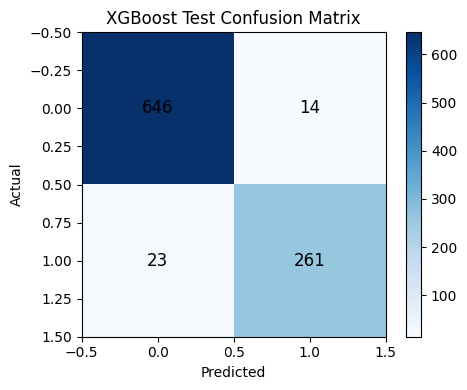

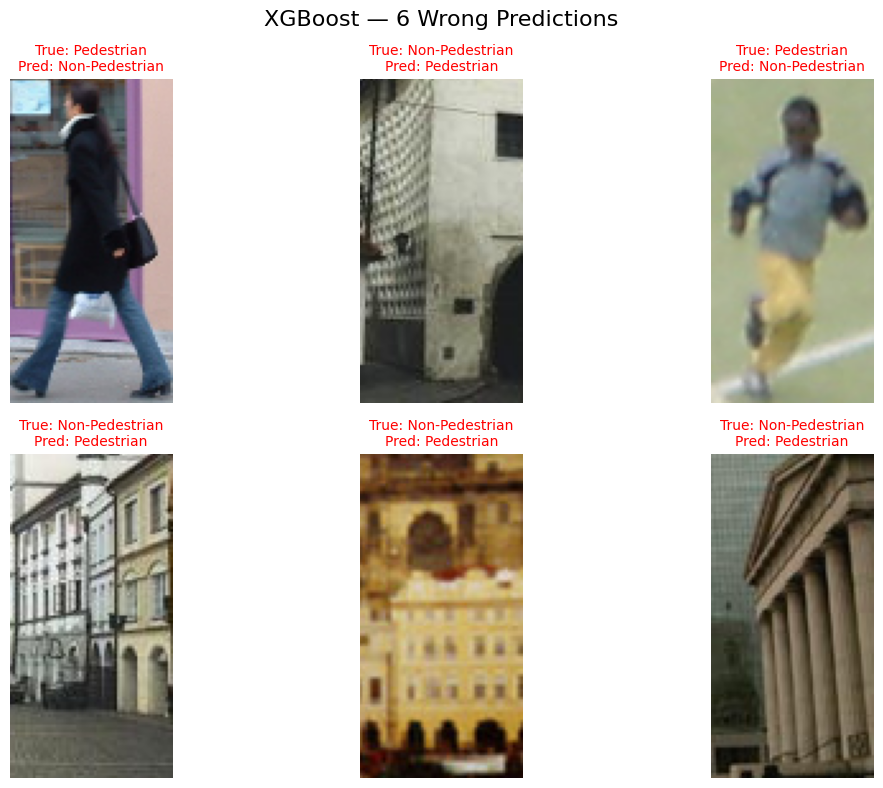

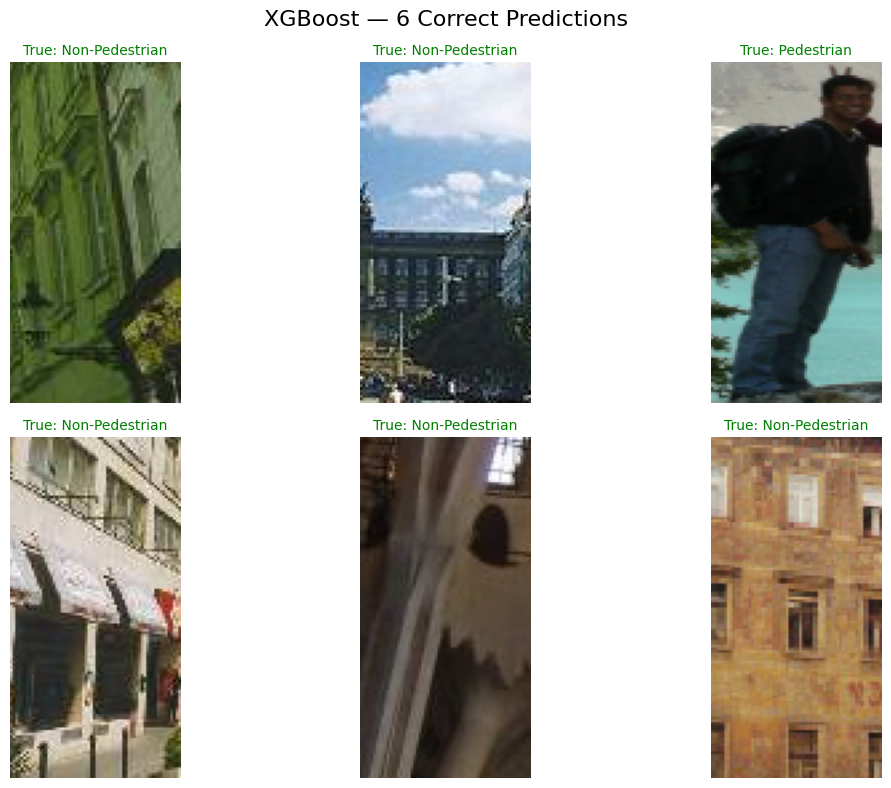


Testing Model: Neural_Network
Neural_Network Test Accuracy: 0.9682
              precision    recall  f1-score   support

    Negative       0.97      0.98      0.98       660
    Positive       0.96      0.93      0.95       284

    accuracy                           0.97       944
   macro avg       0.97      0.96      0.96       944
weighted avg       0.97      0.97      0.97       944



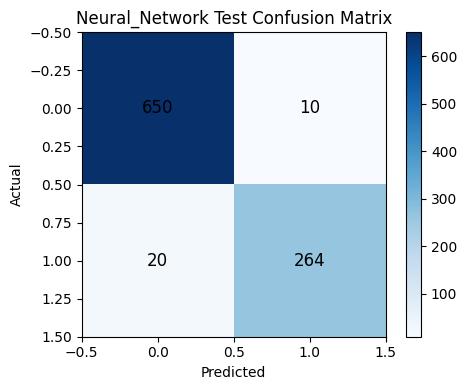

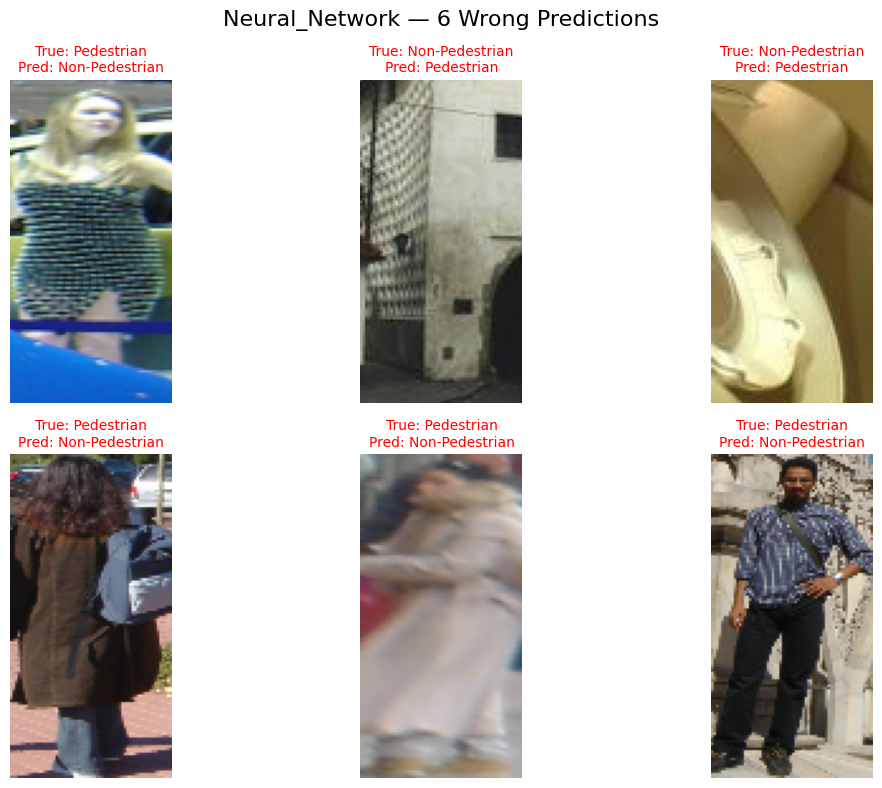

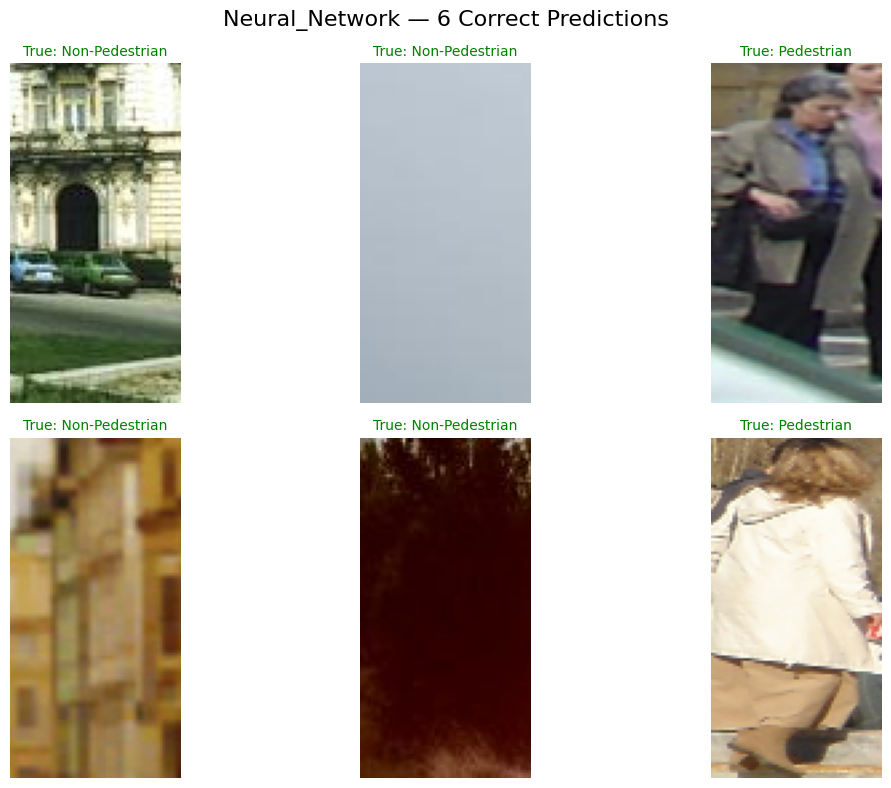

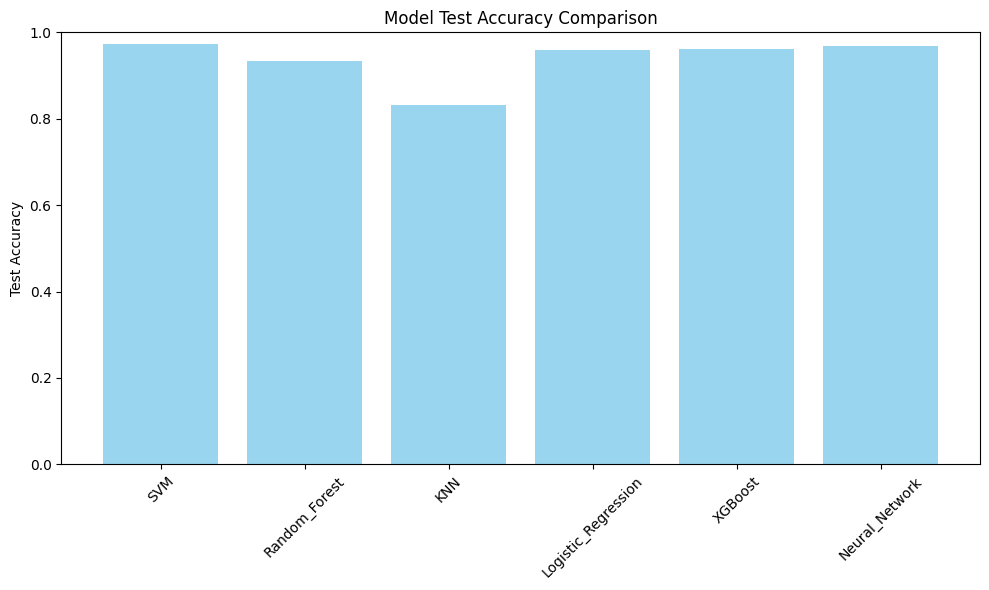

In [ ]:

# test data
test_pos = load_pos("../INRIAPerson/Test/pos")
test_neg = load_neg("../INRIAPerson/Test/neg")
test_acc_list = []

X_test_imgs = test_pos + test_neg
y_test = np.array([1]*len(test_pos) + [0]*len(test_neg))

print(f"Test samples: {len(X_test_imgs)}")

X_test_hog = extract_hog_features(X_test_imgs)

scaler = joblib.load("Models/scaler.joblib")  

X_test_norm = scaler.transform(X_test_hog)

model_names = ["SVM", "Random_Forest", "KNN", "Logistic_Regression", "XGBoost", "Neural_Network"]

for name in model_names:
    print("\n" + "="*50)
    print(f"Testing Model: {name}")
    print("="*50)
    
    # Load trained model
    model = joblib.load(f"Models/{name}.joblib")
    
    # Predict
    test_pred = model.predict(X_test_norm)
    test_acc = accuracy_score(y_test, test_pred)
    test_acc_list.append(test_acc)
    
    print(f"{name} Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, test_pred, target_names=['Negative','Positive']))
    
    # -------- Confusion Matrix --------
    cm = confusion_matrix(y_test, test_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"{name} Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.colorbar()
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', va='center', color='black', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # visualize predictions
    correct_idx = np.where(test_pred == y_test)[0]
    wrong_idx = np.where(test_pred != y_test)[0]
    correct_sample = np.random.choice(correct_idx, min(6, len(correct_idx)), replace=False)
    wrong_sample = np.random.choice(wrong_idx, min(6, len(wrong_idx)), replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()
    for i, idx in enumerate(wrong_sample):
         img = cv2.cvtColor(X_test_imgs[idx], cv2.COLOR_BGR2RGB)
         true_label = 'Pedestrian' if y_test[idx] == 1 else 'Non-Pedestrian'
         pred_label = 'Pedestrian' if test_pred[idx] == 1 else 'Non-Pedestrian'
         axes[i].imshow(img)
         axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color='red', fontsize=10)
         axes[i].axis('off')
    
    plt.suptitle(f"{name} — 6 Wrong Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(2,3,figsize=(12,8))
    axes = axes.ravel()
    for i, idx in enumerate(correct_sample):
        img = cv2.cvtColor(X_test_imgs[idx], cv2.COLOR_BGR2RGB)
        label = 'Pedestrian' if y_test[idx]==1 else 'Non-Pedestrian'
        axes[i].imshow(img)
        axes[i].set_title(f'True: {label}', color='green', fontsize=10)
        axes[i].axis('off')
    plt.suptitle(f"{name} — 6 Correct Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

# Test Accuracy Comparison
plt.figure(figsize=(10,6))
x_pos = np.arange(len(model_names))
plt.bar(x_pos, test_acc_list, color='skyblue', alpha=0.85)
plt.xticks(x_pos, model_names, rotation=45)
plt.ylabel("Test Accuracy")
plt.title("Model Test Accuracy Comparison")
plt.ylim(0,1)
plt.tight_layout()
plt.show()